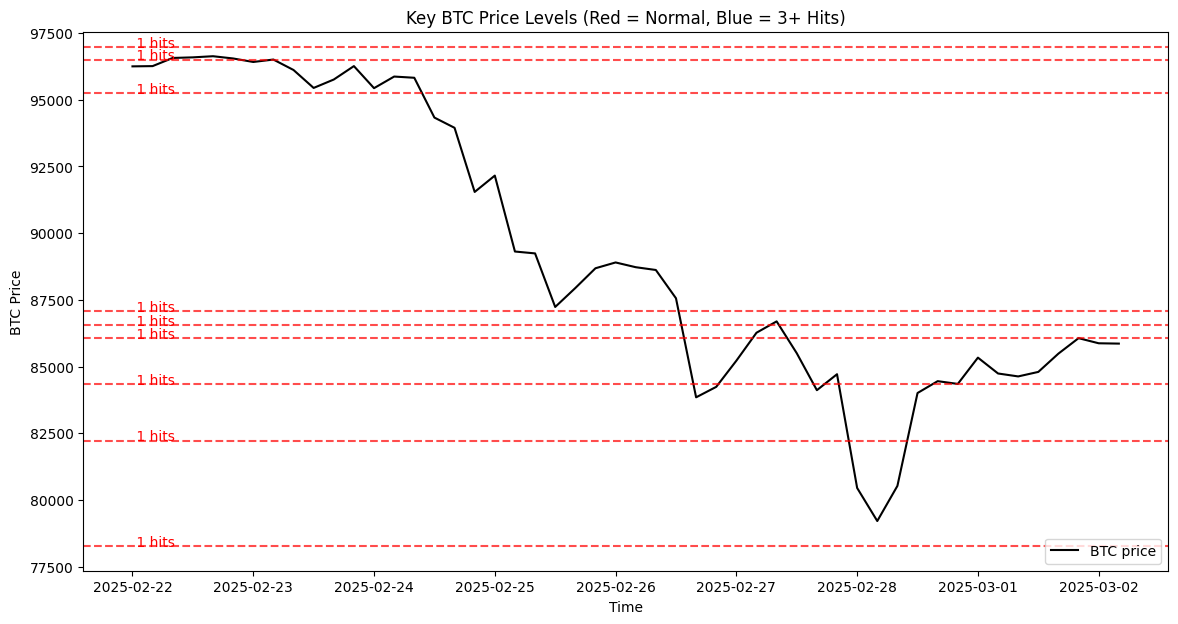

🔹 سطوح کلیدی شناسایی‌شده:
🔴 78264.29 → 1 بار برخورد
🔴 82222.87 → 1 بار برخورد
🔴 84331.88 → 1 بار برخورد
🔴 86055.35 → 1 بار برخورد
🔴 86558.17 → 1 بار برخورد
🔴 87071.12 → 1 بار برخورد
🔴 95243.93 → 1 بار برخورد
🔴 96499.66 → 1 بار برخورد
🔴 96971.63 → 1 بار برخورد


In [4]:
from pybit.unified_trading import HTTP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from finta import TA

# اتصال به Bybit (در حالت تست‌نت)
url = HTTP(testnet=True)
response = url.get_index_price_kline(
    category="linear",
    symbol="BTCUSDT",
    interval=240,  # تایم‌فریم 4 ساعته
    limit=50,
)

# تبدیل داده به DataFrame
if 'result' in response:
    kline_data = response['result']
    df = pd.DataFrame(kline_data)
    df[['timestamp', 'open', 'high', 'low', 'close']] = pd.DataFrame(df['list'].to_list(), index=df.index)
    df.drop(columns=['list', 'category'], inplace=True)
    df['timestamp'] = pd.to_numeric(df['timestamp'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['EMA_50'] = TA.EMA(df, 50)
    df[['open', 'high', 'low', 'close']] = df[['open', 'high', 'low', 'close']].astype(float)

# پیدا کردن سطوح کلیدی (بررسی تمام مقادیر: Open, High, Low, Close)
def find_key_levels(df, sensitivity=0.001):
    levels = []
    hits_count = Counter()

    for i in range(2, len(df) - 2):
        prices = [df['open'][i], df['high'][i], df['low'][i], df['close'][i]]

        for price in prices:
            # بررسی سقف (High) و قیمت‌های دیگر
            if (df['high'][i-2] < price and df['high'][i-1] < price and 
                df['high'][i+1] < price and df['high'][i+2] < price):
                levels.append(price)
                hits_count[price] += 1

            # بررسی کف (Low) و قیمت‌های دیگر
            if (df['low'][i-2] > price and df['low'][i-1] > price and 
                df['low'][i+1] > price and df['low'][i+2] > price):
                levels.append(price)
                hits_count[price] += 1

    # فیلتر کردن سطوح نزدیک به هم
    final_levels = {}
    for level in sorted(levels):
        if not final_levels or abs(list(final_levels.keys())[-1] - level) > sensitivity * level:
            final_levels[level] = hits_count[level]

    return final_levels

key_levels = find_key_levels(df)

# رسم نمودار قیمت و نمایش سطوح کلیدی
plt.figure(figsize=(14, 7))
plt.plot(df['timestamp'], df['close'], label="BTC price", color='black')

# رسم خطوط افقی برای سطوح کلیدی
for level, count in key_levels.items():
    color = "red" if count < 3 else "blue"  # سطوح با ۳ برخورد یا بیشتر آبی می‌شوند
    plt.axhline(y=level, linestyle="--", color=color, alpha=0.7)
    plt.text(df['timestamp'].iloc[-1], level, f" {count} hits", color=color, fontsize=10)

plt.xlabel("Time")
plt.ylabel("BTC Price")
plt.title("Key BTC Price Levels (Red = Normal, Blue = 3+ Hits)")
plt.legend()
plt.show()

# نمایش قیمت‌های مهم در کنسول
print("🔹 سطوح کلیدی شناسایی‌شده:")
for level, count in key_levels.items():
    color_tag = "🔵" if count >= 3 else "🔴"
    print(f"{color_tag} {level:.2f} → {count} بار برخورد")


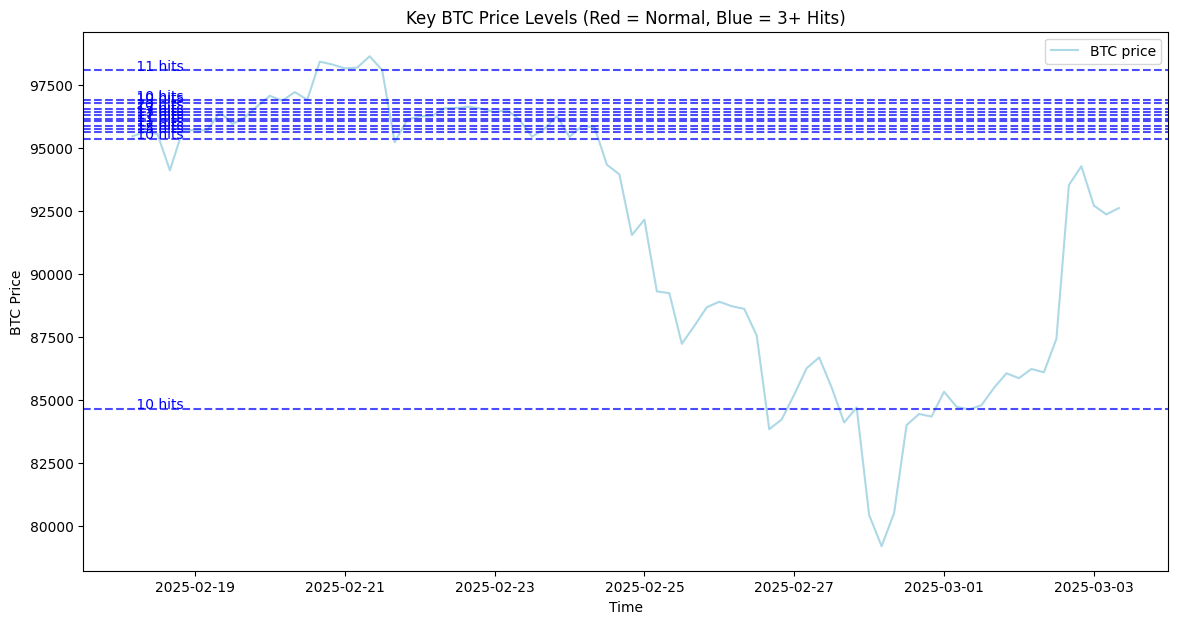

🔹 سطوح کلیدی شناسایی‌شده:
🔵 84655.45 → 10 بار برخورد
🔵 95361.10 → 10 بار برخورد
🔵 95629.72 → 15 بار برخورد
🔵 95737.52 → 12 بار برخورد
🔵 95875.15 → 11 بار برخورد
🔵 96056.47 → 11 بار برخورد
🔵 96158.35 → 17 بار برخورد
🔵 96298.46 → 13 بار برخورد
🔵 96420.40 → 17 بار برخورد
🔵 96549.08 → 20 بار برخورد
🔵 96786.36 → 10 بار برخورد
🔵 96893.12 → 10 بار برخورد
🔵 98083.95 → 11 بار برخورد


In [10]:
from pybit.unified_trading import HTTP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from finta import TA

# اتصال به Bybit (در حالت تست‌نت)
url = HTTP(testnet=True)
response = url.get_index_price_kline(
    category="linear",
    symbol="BTCUSDT",
    interval=240,  # تایم‌فریم 4 ساعته
    limit=80,
)

# تبدیل داده به DataFrame
if 'result' in response:
    kline_data = response['result']
    df = pd.DataFrame(kline_data)
    df[['timestamp', 'open', 'high', 'low', 'close']] = pd.DataFrame(df['list'].to_list(), index=df.index)
    df.drop(columns=['list', 'category'], inplace=True)
    df['timestamp'] = pd.to_numeric(df['timestamp'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['EMA_50'] = TA.EMA(df, 50)
    df[['open', 'high', 'low', 'close']] = df[['open', 'high', 'low', 'close']].astype(float)

# پیدا کردن سطوحی که حداقل 3 برخورد داشته باشند
def find_strong_levels(df, sensitivity=0.001, min_hits=10):
    levels = {}

    for price in df['high'].tolist() + df['low'].tolist():  # بررسی تمامی سقف و کف‌ها
        close_prices = df[['open', 'close', 'high', 'low']].values.flatten()  # همه قیمت‌ها
        close_prices = close_prices.astype(float)
        price = float(price)
        hits = np.sum(np.abs(close_prices - price) / price < sensitivity)  # شمارش برخوردها
        if hits >= min_hits:
            levels[price] = hits

    # فیلتر کردن سطوح خیلی نزدیک به هم
    final_levels = {}
    sorted_levels = sorted(levels.keys())

    for i, level in enumerate(sorted_levels):
        if i == 0:
            final_levels[level] = levels[level]
        else:
            prev_level = list(final_levels.keys())[-1]
            if abs(prev_level - level) > sensitivity * level:
                final_levels[level] = levels[level]

    return final_levels

key_levels = find_strong_levels(df)

# رسم نمودار قیمت و نمایش سطوح کلیدی
plt.figure(figsize=(14, 7))
plt.plot(df['timestamp'], df['close'], label="BTC price", color='lightblue')

# رسم خطوط افقی برای سطوح کلیدی
for level, count in key_levels.items():
    color = "red" if count < 5 else "blue"  # سطوح با ۳ برخورد یا بیشتر آبی می‌شوند
    plt.axhline(y=level, linestyle="--", color=color, alpha=0.7)
    plt.text(df['timestamp'].iloc[-1], level, f" {count} hits", color=color, fontsize=10)

plt.xlabel("Time")
plt.ylabel("BTC Price")
plt.title("Key BTC Price Levels (Red = Normal, Blue = 3+ Hits)")
plt.legend()
plt.show()

# نمایش قیمت‌های مهم در کنسول
print("🔹 سطوح کلیدی شناسایی‌شده:")
for level, count in key_levels.items():
    color_tag = "🔵" if count >= 5 else "🔴"
    print(f"{color_tag} {level:.2f} → {count} بار برخورد")

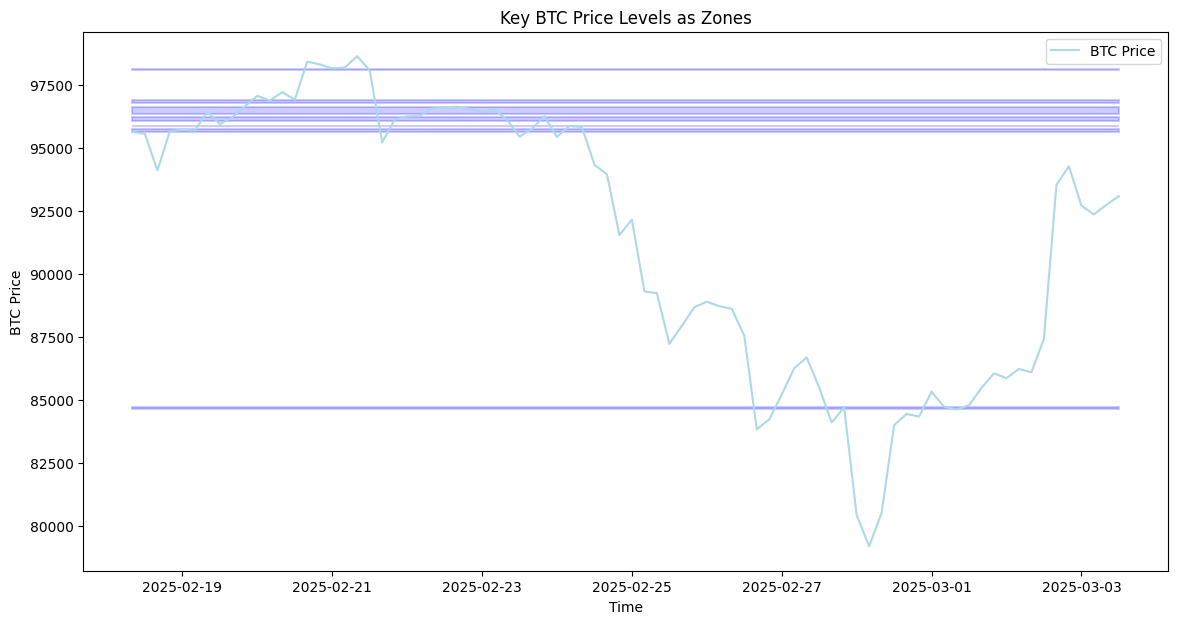

🔹 مناطق کلیدی شناسایی‌شده:
🟦 منطقه بین 84655.45 تا 84734.59
🟦 منطقه بین 95629.72 تا 95737.52
🟦 منطقه بین 95875.15 تا 95878.29
🟦 منطقه بین 96056.47 تا 96225.41
🟦 منطقه بین 96330.25 تا 96638.45
🟦 منطقه بین 96786.36 تا 96893.12
🟦 منطقه بین 98083.95 تا 98123.73


In [12]:
from pybit.unified_trading import HTTP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from finta import TA

# اتصال به Bybit (در حالت تست‌نت)
url = HTTP(testnet=True)
response = url.get_index_price_kline(
    category="linear",
    symbol="BTCUSDT",
    interval=240,  # تایم‌فریم 4 ساعته
    limit=80,
)

# تبدیل داده به DataFrame
if 'result' in response:
    kline_data = response['result']
    df = pd.DataFrame(kline_data)
    df[['timestamp', 'open', 'high', 'low', 'close']] = pd.DataFrame(df['list'].to_list(), index=df.index)
    df.drop(columns=['list', 'category'], inplace=True)
    df['timestamp'] = pd.to_numeric(df['timestamp'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['EMA_50'] = TA.EMA(df, 50)
    df[['open', 'high', 'low', 'close']] = df[['open', 'high', 'low', 'close']].astype(float)

# پیدا کردن سطوحی که حداقل 3 برخورد داشته باشند
def find_strong_levels(df, sensitivity=0.001, min_hits=10):
    levels = {}

    for price in df['high'].tolist() + df['low'].tolist():  # بررسی تمامی سقف و کف‌ها
        close_prices = df[['open', 'close', 'high', 'low']].values.flatten()  # همه قیمت‌ها
        close_prices = close_prices.astype(float)
        price = float(price)
        hits = np.sum(np.abs(close_prices - price) / price < sensitivity)  # شمارش برخوردها
        if hits >= min_hits:
            levels[price] = hits

    # ترکیب سطوح نزدیک به هم
    zones = []
    sorted_levels = sorted(levels.keys())
    
    merged_zone = [sorted_levels[0]]  # شروع اولین منطقه
    for level in sorted_levels[1:]:
        if abs(level - merged_zone[-1]) < sensitivity * level:
            merged_zone.append(level)
        else:
            zones.append((min(merged_zone), max(merged_zone)))  # ذخیره منطقه قبلی
            merged_zone = [level]  # شروع منطقه جدید

    if merged_zone:
        zones.append((min(merged_zone), max(merged_zone)))  # ذخیره آخرین منطقه

    return zones

zones = find_strong_levels(df)

# رسم نمودار قیمت و نمایش سطوح کلیدی به شکل مستطیل
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(df['timestamp'], df['close'], label="BTC Price", color='lightblue')

# رسم مستطیل‌ها به‌صورت کامل در عرض چارت
for zone in zones:
    bottom, top = zone
    rect = Rectangle(
        (df['timestamp'].min(), bottom),  # شروع از اولین تایم‌استمپ
        df['timestamp'].max() - df['timestamp'].min(),  # طول مستطیل تا آخرین تایم‌استمپ
        top - bottom,  # ارتفاع منطقه
        linewidth=1.5, edgecolor="blue", facecolor="blue", alpha=0.2
    )
    ax.add_patch(rect)

plt.xlabel("Time")
plt.ylabel("BTC Price")
plt.title("Key BTC Price Levels as Zones")
plt.legend()
plt.show()

# نمایش مناطق کلیدی در کنسول
print("🔹 مناطق کلیدی شناسایی‌شده:")
for zone in zones:
    print(f"🟦 منطقه بین {zone[0]:.2f} تا {zone[1]:.2f}")


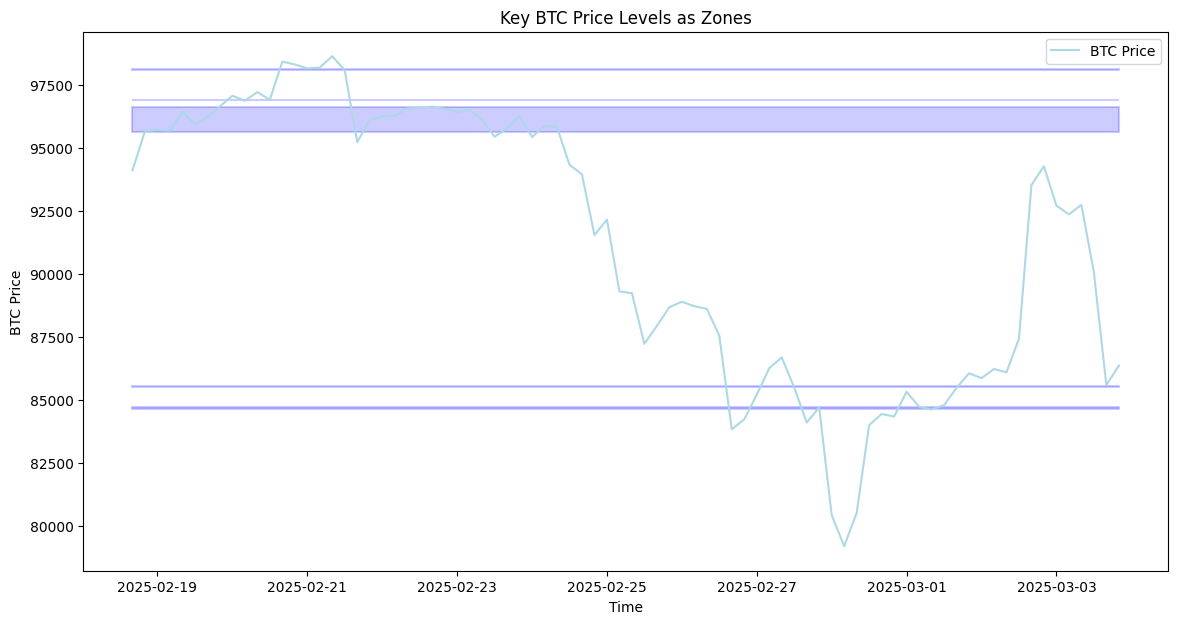

🔹 مناطق کلیدی شناسایی‌شده:
🟦 منطقه بین 84655.45 تا 84734.59
🟦 منطقه بین 85504.31 تا 85579.28
🟦 منطقه بین 95629.72 تا 96638.45
🟦 منطقه بین 96881.09 تا 96893.12
🟦 منطقه بین 98083.95 تا 98123.73


In [1]:
from pybit.unified_trading import HTTP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from finta import TA

# اتصال به Bybit (در حالت تست‌نت)
url = HTTP(testnet=True)
response = url.get_index_price_kline(
    category="linear",
    symbol="BTCUSDT",
    interval=240,  # تایم‌فریم 4 ساعته
    limit=80,
)

# تبدیل داده به DataFrame
if 'result' in response:
    kline_data = response['result']
    df = pd.DataFrame(kline_data)
    df[['timestamp', 'open', 'high', 'low', 'close']] = pd.DataFrame(df['list'].to_list(), index=df.index)
    df.drop(columns=['list', 'category'], inplace=True)
    df['timestamp'] = pd.to_numeric(df['timestamp'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['EMA_50'] = TA.EMA(df, 50)
    df[['open', 'high', 'low', 'close']] = df[['open', 'high', 'low', 'close']].astype(float)

# پیدا کردن سطوح کلیدی
def find_strong_levels(df, sensitivity=0.001, min_hits=10, merge_distance=0.002):
    levels = {}

    for price in df['high'].tolist() + df['low'].tolist():  # بررسی تمامی سقف و کف‌ها
        close_prices = df[['open', 'close', 'high', 'low']].values.flatten()  # همه قیمت‌ها
        close_prices = close_prices.astype(float)
        price = float(price)
        hits = np.sum(np.abs(close_prices - price) / price < sensitivity)  # شمارش برخوردها
        if hits >= min_hits:
            levels[price] = hits

    # ترکیب سطوح نزدیک به هم
    zones = []
    sorted_levels = sorted(levels.keys())

    merged_zone = [sorted_levels[0]]  # شروع اولین منطقه
    for level in sorted_levels[1:]:
        if abs(level - merged_zone[-1]) < sensitivity * level:
            merged_zone.append(level)
        else:
            zones.append((min(merged_zone), max(merged_zone)))  # ذخیره منطقه قبلی
            merged_zone = [level]  # شروع منطقه جدید

    if merged_zone:
        zones.append((min(merged_zone), max(merged_zone)))  # ذخیره آخرین منطقه

    # **مرج کردن مناطق نزدیک به هم**
    merged_zones = []
    merged_zone = zones[0]

    for zone in zones[1:]:
        if abs(zone[0] - merged_zone[1]) / zone[0] < merge_distance:
            merged_zone = (merged_zone[0], zone[1])  # ترکیب مناطق
        else:
            merged_zones.append(merged_zone)
            merged_zone = zone

    merged_zones.append(merged_zone)  # ذخیره آخرین منطقه

    return merged_zones

zones = find_strong_levels(df)

# رسم نمودار قیمت و نمایش مناطق کلیدی به شکل مستطیل
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(df['timestamp'], df['close'], label="BTC Price", color='lightblue')

# رسم مستطیل‌ها
for zone in zones:
    bottom, top = zone
    rect = Rectangle(
        (df['timestamp'].min(), bottom),  # شروع از اولین تایم‌استمپ
        df['timestamp'].max() - df['timestamp'].min(),  # طول مستطیل تا آخرین تایم‌استمپ
        top - bottom,  # ارتفاع منطقه
        linewidth=1.5, edgecolor="blue", facecolor="blue", alpha=0.2
    )
    ax.add_patch(rect)

plt.xlabel("Time")
plt.ylabel("BTC Price")
plt.title("Key BTC Price Levels as Zones")
plt.legend()
plt.show()

# نمایش مناطق کلیدی در کنسول
print("🔹 مناطق کلیدی شناسایی‌شده:")
for zone in zones:
    print(f"🟦 منطقه بین {zone[0]:.2f} تا {zone[1]:.2f}")


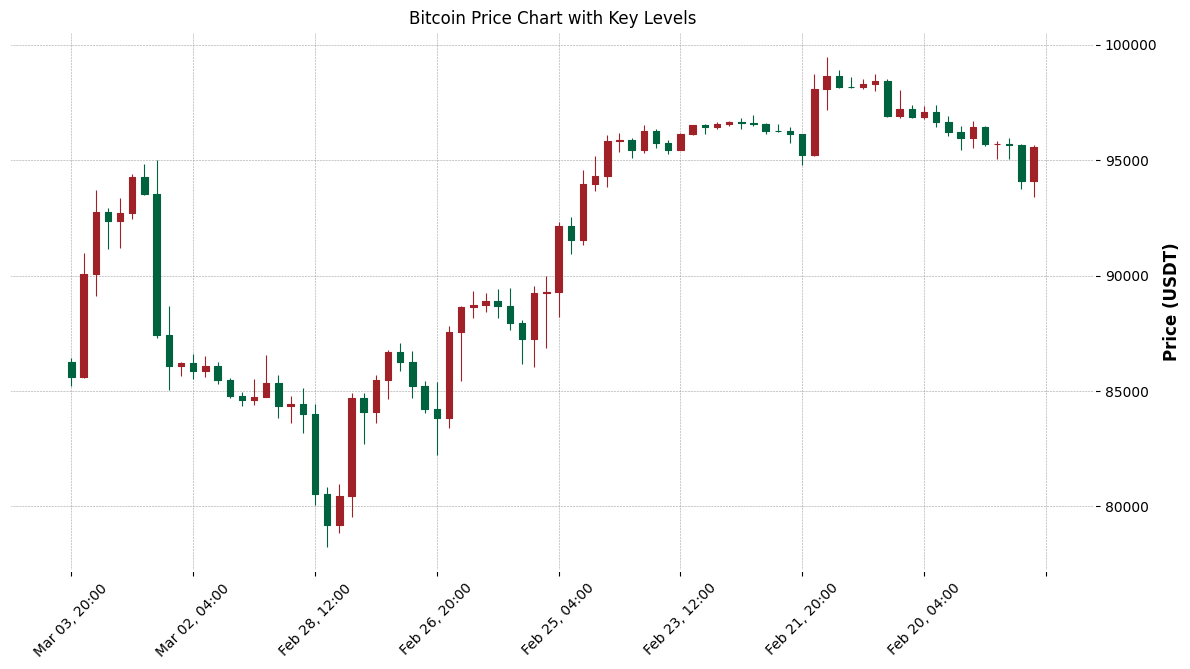

🔹 مناطق کلیدی شناسایی‌شده:
🟦 منطقه بین 84655.45 تا 84734.59
🟦 منطقه بین 85504.31 تا 85579.28
🟦 منطقه بین 95629.72 تا 96638.45
🟦 منطقه بین 96881.09 تا 96893.12
🟦 منطقه بین 98083.95 تا 98123.73


In [5]:
from pybit.unified_trading import HTTP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
from matplotlib.patches import Rectangle
from finta import TA

# اتصال به Bybit (در حالت تست‌نت)
url = HTTP(testnet=True)
response = url.get_index_price_kline(
    category="linear",
    symbol="BTCUSDT",
    interval=240,  # تایم‌فریم 4 ساعته
    limit=80,
)

# تبدیل داده به DataFrame
if 'result' in response:
    kline_data = response['result']
    df = pd.DataFrame(kline_data)
    df[['timestamp', 'open', 'high', 'low', 'close']] = pd.DataFrame(df['list'].to_list(), index=df.index)
    df.drop(columns=['list', 'category'], inplace=True)
    df['timestamp'] = pd.to_numeric(df['timestamp'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['EMA_50'] = TA.EMA(df, 50)
    df[['open', 'high', 'low', 'close']] = df[['open', 'high', 'low', 'close']].astype(float)

# پیدا کردن سطوح کلیدی
def find_strong_levels(df, sensitivity=0.001, min_hits=10, merge_distance=0.002):
    levels = {}

    for price in df['high'].tolist() + df['low'].tolist():  # بررسی تمامی سقف و کف‌ها
        close_prices = df[['open', 'close', 'high', 'low']].values.flatten()  # همه قیمت‌ها
        close_prices = close_prices.astype(float)
        price = float(price)
        hits = np.sum(np.abs(close_prices - price) / price < sensitivity)  # شمارش برخوردها
        if hits >= min_hits:
            levels[price] = hits

    # ترکیب سطوح نزدیک به هم
    zones = []
    sorted_levels = sorted(levels.keys())

    merged_zone = [sorted_levels[0]]  # شروع اولین منطقه
    for level in sorted_levels[1:]:
        if abs(level - merged_zone[-1]) < sensitivity * level:
            merged_zone.append(level)
        else:
            zones.append((min(merged_zone), max(merged_zone)))  # ذخیره منطقه قبلی
            merged_zone = [level]  # شروع منطقه جدید

    if merged_zone:
        zones.append((min(merged_zone), max(merged_zone)))  # ذخیره آخرین منطقه

    # **مرج کردن مناطق نزدیک به هم**
    merged_zones = []
    merged_zone = zones[0]

    for zone in zones[1:]:
        if abs(zone[0] - merged_zone[1]) / zone[0] < merge_distance:
            merged_zone = (merged_zone[0], zone[1])  # ترکیب مناطق
        else:
            merged_zones.append(merged_zone)
            merged_zone = zone

    merged_zones.append(merged_zone)  # ذخیره آخرین منطقه

    return merged_zones

zones = find_strong_levels(df)

# **تنظیم `timestamp` به عنوان index برای mplfinance**
df.set_index("timestamp", inplace=True)

# **ایجاد مستطیل‌های مناطق کلیدی برای `mplfinance`**
rectangles = []
for zone in zones:
    bottom, top = zone
    rect = Rectangle(
        (df.index.min(), bottom),  # شروع از اولین تایم‌استمپ
        df.index.max() - df.index.min(),  # طول مستطیل تا آخرین تایم‌استمپ
        top - bottom,  # ارتفاع منطقه
        linewidth=1.5, edgecolor="blue", facecolor="blue", alpha=0.2
    )
    rectangles.append(rect)

# **تنظیم `mplfinance` برای نمایش کندل‌ها همراه با مناطق کلیدی**
fig, ax = plt.subplots(figsize=(14, 7))

# رسم نمودار کندل‌استیک
mpf.plot(
    df,
    type="candle",         # نمودار شمعی
    style="charles",       # سبک نمایش
    ax=ax,                 # استفاده از محور مشترک
    ylabel="Price (USDT)",
    volume=False,          # عدم نمایش حجم
)

# افزودن مستطیل‌ها به نمودار
for rect in rectangles:
    ax.add_patch(rect)

plt.title("Bitcoin Price Chart with Key Levels")
plt.show()

# نمایش مناطق کلیدی در کنسول
print("🔹 مناطق کلیدی شناسایی‌شده:")
for zone in zones:
    print(f"🟦 منطقه بین {zone[0]:.2f} تا {zone[1]:.2f}")


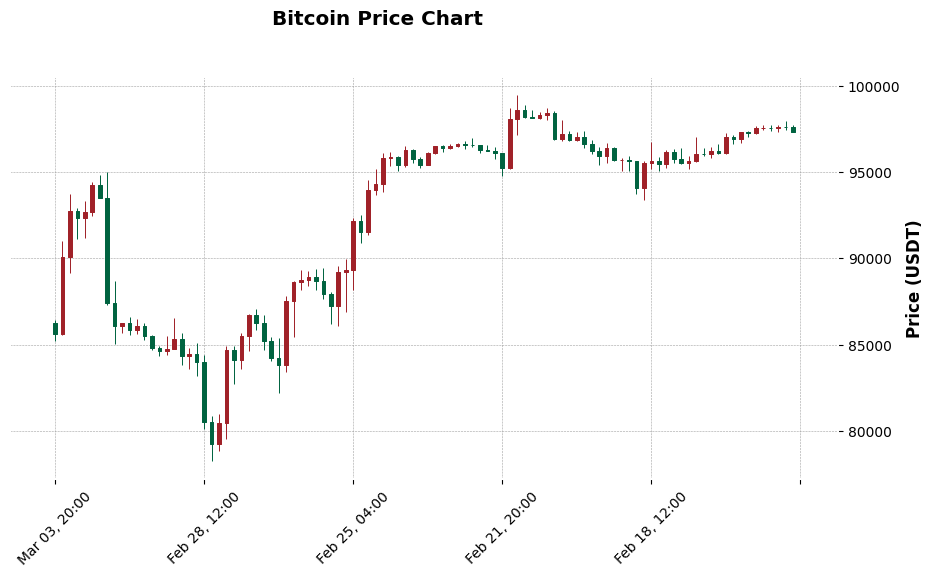

In [4]:
from pybit.unified_trading import HTTP
import pandas as pd
import mplfinance as mpf

# اتصال به Bybit (در حالت تست‌نت)
url = HTTP(testnet=True)
response = url.get_index_price_kline(
    category="linear",
    symbol="BTCUSDT",
    interval=240,  # تایم‌فریم 4 ساعته
    limit=100,
)

# تبدیل داده به DataFrame
if 'result' in response:
    kline_data = response['result']
    df = pd.DataFrame(kline_data)
    df[['timestamp', 'open', 'high', 'low', 'close']] = pd.DataFrame(df['list'].to_list(), index=df.index)
    df.drop(columns=['list', 'category'], inplace=True)
    df['timestamp'] = pd.to_numeric(df['timestamp'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df[['open', 'high', 'low', 'close']] = df[['open', 'high', 'low', 'close']].astype(float)

    # تبدیل DataFrame به فرمت مورد نیاز برای mplfinance

    df.set_index("timestamp", inplace=True)  # تنظیم ستون timestamp به عنوان index

    # رسم نمودار شمعی (Candlestick Chart)
    mpf.plot(
        df,
        type="candle",         # نمودار شمعی
        style="charles",       # سبک نمایش
        title="Bitcoin Price Chart",
        ylabel="Price (USDT)",
        volume=False,          # نمایش ندادن حجم معاملات
        figratio=(14, 7),      # نسبت ابعاد
    )
